## Assignment 3 - Solving the MountainCar problem using Actor-Critic Models

**Lecture 5** introduced you to the Actor Critic family of models: A2C, DA2C, NDA2C

In this assignment, you need to use the DA2C and NDA2C models to solve for OpenAI gym MountainCar problem (https://gym.openai.com/envs/MountainCar-v0/)

```Note1```: MountainCar-v0 defines "solving" as getting average reward of -110.0 over 100 consecutive trials. (https://github.com/openai/gym/wiki/MountainCar-v0)

```Note2```: Use transformed rewards if need be.

### A. Tasks
In this assignment, you are required to solve for the **OpenAI gym - MountainCar-v0** problem using **A2C Models**: DA2C and NDA2C. 
Your report should compare the scores from using both models. Please input your code for the DA2C and NDA2C into ```B: Answer-DA2C``` and ```C: Answer-NDA2C``` respectively.

```You should write and test your solutions as python files rather than jupyter notebooks as multi processing in jupyter notebooks may generate issues. Once you have written and tested your code, **COPY** it into the relevant sections of this jupyter notebook and upload it to canvas.```

- Your code should consist of a deep ANN model for both the actor and critic. Use your own judgment on the architecture and hyperparameters of the network. 
- A training loop to learn from the environment
- After training, test the model on a fresh instance of the environment. Report on the score received after one episode / game.
- Report on the training score / reward over the trained episodes as graph
- Report on the test score, is the problem solved?


```Note3```: If part of your code is not working or you have difficulty getting an optimal solution, write your intuition/explanation of what you wanted to achieve as comments prior to that part of the code/function



### B. Answer-DA2C

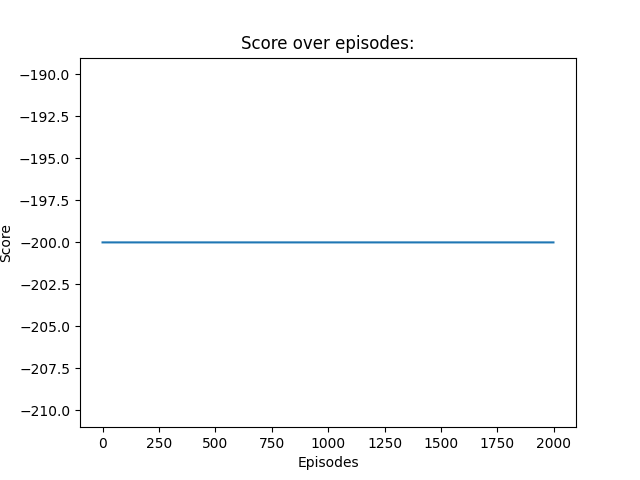

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import gym
import torch
import multiprocessing as mp
import copy

"""
I was not able to solve the mountain car problem with neither DA2C nor the NDA2C model.
I think the problem is that the model does not randomly stumble upon the solution. I tried
changing the reward function so that the agents would regard number of iterations, relative
movements and distance from the finish position when calculating reward. Nothing worked out. 

The test score for DA2C and NDA2C was -200, ergo, problem not solved. 
"""


class A2C:
    def __init__(self, env, h1, lr):
        torch.seed = 999
        torch.manual_seed(torch.seed)
        np.random.seed(torch.seed)

        self.env = env
        self.env.seed = torch.seed

        self.state_dim = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n

        self.actor = self.init_actor(h1)
        self.critic = self.init_critic(h1)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=lr)
        self.critic_loss_func = torch.nn.MSELoss()


    def init_actor(self, h1):
        actor = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim, h1),
            torch.nn.ReLU(),
            torch.nn.Linear(h1, self.n_actions),
            torch.nn.Softmax(dim=-1)
        )
        return actor

    def init_critic(self, h1):
        critic = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim, h1),
            torch.nn.ReLU(),
            torch.nn.Linear(h1, 1),
        )
        return critic

    def actor_loss(self, probs, adv):
        loss =  -1 * torch.sum(torch.log(probs) * adv)
        return loss

    def choose_action(self, policy):
        action = np.random.choice(
            self.n_actions,
            p=policy.detach().numpy()
        )
        return action

    def calc_returns(self, last_return, rewards, gamma):
        returns = []
        for ret in range(rewards.shape[0]):
            return_ = rewards[ret] + gamma * last_return
            returns.append(return_)
        return torch.concat(returns)

    def print_progress(self, ep_counter, epoch, max_epochs, worker_id, score):
        if ep_counter % np.round(max_epochs/10) == 0:
            print(f'worker: {worker_id}, epoch:{epoch}, episode: {ep_counter:d}, score: {score:.2f}')

    def store_progress(self, info, ep_counter, score):
        info[ep_counter] = {
            'score': info[ep_counter]['score'] + score, 'count': info[ep_counter]['count'] + 1} if info.get(
                        ep_counter) else {'score': score, 'count': 1}
        return info

    def train(self):
        raise NotImplementedError

    def test(self, render=False, max_moves=500, ):
        state = self.env.reset()
        done = False
        score = 0

        for _ in range(max_moves):
            if done: break
            if render:
                self.env.render()

            policy = self.actor(torch.from_numpy(state).float())
            action = self.choose_action(policy)

            state, reward, done, _ = self.env.step(action)
            score += reward
        
        print(f'Test reward: {score}')


    def plot(self, info):
        episodes = [k for k in info.keys()]
        relative_score = [v["score"]/v["count"] for v in info.values()]

        plt.plot(episodes, relative_score)
        plt.title('Scores over episodes:')
        plt.xlabel('episode')
        plt.ylabel('score')
        plt.show()


class DA2C(A2C):    
    def partial_train(self, i, params, info):
        env = copy.deepcopy(self.env)
        scores = []
        gamma = params["gamma"]
        epochs = params['epochs']

        for e in range(epochs):
            state = env.reset()
            values, probs, rewards = [], [], []
            done = False
            score = 0
            max_moves = 200
            
            for _ in range(max_moves):
                if done: break
            
                value = self.critic(torch.from_numpy(state).float())
                policy = self.actor(torch.from_numpy(state).float())                
                action = self.choose_action(policy)

                state, reward, done, _ = env.step(action)

                values.append(value)
                probs.append(policy[action])
                rewards.append(reward)
                score += reward
            
            scores.append(score)            
            
            values = torch.concat(values).flip(
                dims=(0, ))                     
            probs = torch.stack(probs).flip(
                dims=(0, ))
            rewards = torch.Tensor(rewards).flip(dims=(0, ))            

            
            return_ = torch.Tensor([0])
            returns = self.calc_returns(return_, rewards, gamma)
                    
            critic_loss = self.critic_loss_func(values, returns)

            advantage = returns - values.detach()
            actor_loss = self.actor_loss(probs, advantage)            
         
            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()

            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()            
            

            self.print_progress(e, e, epochs, i, score)
            info = self.store_progress(info, e, score)
          

    def train(self, params):
        self.actor.share_memory()
        self.critic.share_memory()
        
        processes = []
        info = mp.Manager().dict()
        workers = params['workers']
        
        for i in range(workers):
            p = mp.Process(target=self.partial_train, args=(
                i, params, info))
            p.start()
            processes.append(p)

        for p in processes:
            p.join()
        
        for p in processes:
            p.terminate()

        return info


def main():
    training_params = {
        'epochs': 300,  
        'gamma': 0.99,
        'workers': mp.cpu_count() 
    }
    env = gym.make('MountainCar-v0')
    agent = DA2C(env, 150, 4e-4)
    info = agent.train(training_params)

    agent.plot(info)    
    agent.test()

### C. Answer-NDA2C

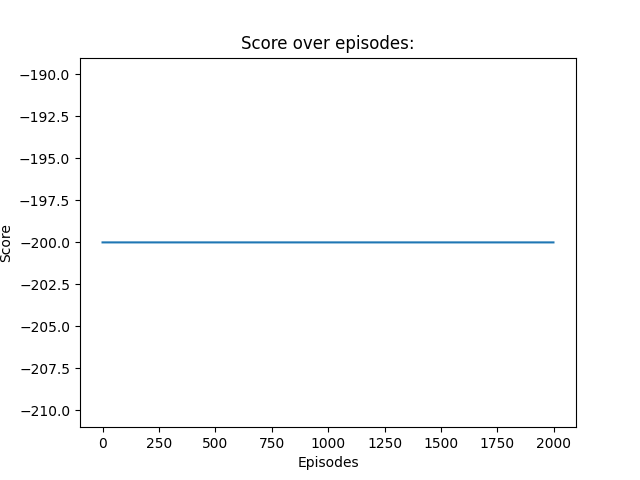

In [2]:
import gym
import torch
import numpy as np
import multiprocessing as mp
import copy


class NDA2C(A2C):
    def partial_train(self, i, params, info):
        env = copy.deepcopy(self.env)
        state = env.reset()
        ep_counter = 0
        score = 0
        gamma = params["gamma"]
        epochs = params['epochs']
        steps = params["nstep"]

        for e in range(epochs):
            done = False
            values, probs, rewards = [], [], []
            G = torch.Tensor([0])

            for step in range(steps):
                if done: break

                value = self.critic(torch.from_numpy(state).float())
                policy = self.actor(torch.from_numpy(state).float())
                action = self.choose_action(policy)

                state, reward, done, _ = env.step(action)
                
                values.append(value)
                probs.append(policy[action])
                rewards.append(reward)
                score += reward
                
                if done:
                    self.print_progress(ep_counter, e, epochs, i, score)
                    info = self.store_progress(info, ep_counter, score)
                    state = env.reset()
                    ep_counter += 1
                    score = 0
                else:
                    G = value.detach()

            values = torch.concat(values).flip(
                dims=(0, ))
            probs = torch.stack(probs).flip(
                dims=(0, ))
            rewards = torch.Tensor(rewards).flip(
                dims=(0, ))

            returns = self.calc_returns(G, rewards, gamma)

            critic_loss = self.critic_loss_func(values, returns)

            advantage = returns - values.detach()
            actor_loss = self.actor_loss(probs, advantage)

            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()

            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()

    def train(self, params):
        self.actor.share_memory()
        self.critic.share_memory()

        processes = []
        info = mp.Manager().dict()
        workers = params["workers"]

        for i in range(workers):
            p = mp.Process(target=self.partial_train, args=(
                i, params, info))
            p.start()
            processes.append(p)

        for p in processes:
            p.join()

        for p in processes:
            p.terminate()

        return info


def main_nda2c():
    env = gym.make('MountainCar-v0')

    agent = NDA2C(env, 150, 1e-3)

    training_params = {
        'epochs': 300,  
        'gamma': 0.99,
        'nstep': 50,
        'workers': mp.cpu_count()
    }
    info = agent.train(training_params)

    agent.plot(info)
    agent.test()